In [1]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar
!rm -rf sample_data

--2022-08-21 08:51:56--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar’

universum_compresse 100%[===================>]  68.69M  8.27MB/s    in 15s     

2022-08-21 08:52:11 (4.57 MB/s) - ‘universum_compressed.tar’ saved [72028160/72028160]



In [2]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 4.7 MB/s 
     |████████████████████████████████| 376 kB 15.1 MB/s 
     |████████████████████████████████| 58 kB 8.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e5ef3ba1c41442d34bfba93ded935bafeb2edd464b7eb8caa52df151254ad943
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=c8fdd589612a97a92ff3286c592756e5152569b4ac272303e0a0750c1706a1eb
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import os
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab, lab2rgb

import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp

In [4]:
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from google.colab import drive

drive.mount("gdrive")

Mounted at gdrive


In [7]:
class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y

        filenames = []
        for root, dirs, files in os.walk(path):
            for image_file in files:
                if image_file.endswith(".jpg") or image_file.endswith(".JPG"):
                    filenames.append(os.path.join(root, image_file))
        
        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        lab = self.transform_y(image)
        l, ab = self.transform_x(lab)

        return l, ab

In [8]:
def normalize_lab(lab):
    l = (lab[0, :, :] / 100.).view(1, 128, 128)
    ab = lab[1:, :, :] / 128.

    return l, ab

def unnormalize_l(l):
    return l * 100.

def unnormalize_ab(ab):
    return ab * 128.


trans_y = transforms.Compose([
    transforms.RandomResizedCrop(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.6),
    transforms.RandomRotation(degrees=(0, 30)),
    transforms.Lambda(rgb2lab),
    transforms.ToTensor()
])


In [9]:
dataset = ColorizationDataset("/content/universum-photos", normalize_lab, trans_y)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 831.68it/s]


In [10]:
def eval(start_idx, end_idx):
    for img_idx in range(start_idx, end_idx):
        l, ab = dataset[img_idx]

        l = l.to(device).float().view(1, 1, 128, 128)
        ab = ab.to(device).float().view(1, 2, 128, 128)

        pred_ab = model(l)

        l = unnormalize_l(l)
        ab = unnormalize_ab(ab)
        pred_ab = unnormalize_ab(pred_ab)

        lab = torch.cat((l, ab), dim=1)
        pred_lab = torch.cat((l, pred_ab), dim=1)

        pred_lab = pred_lab.reshape(3, 128, 128).permute(1, 2, 0).cpu().detach().numpy()
        lab = lab.reshape(3, 128, 128).permute(1, 2, 0).cpu().detach().numpy()
        l = l.cpu().detach().numpy().reshape(128, -1)

        rgb = lab2rgb(lab)
        pred_rgb = lab2rgb(pred_lab)

        plt.figure(figsize=(7, 7))


        plt.subplot(131)
        plt.title("L")
        plt.imshow(l, cmap="gray")
        plt.axis("off")

        plt.subplot(132)
        plt.title("Source")
        plt.axis("off")
        plt.imshow(rgb)

        plt.subplot(133)
        plt.title("Colorized")
        plt.axis("off")
        plt.imshow(pred_rgb)

        plt.show()

In [ ]:
class ColorizerUnet(nn.Module):
    def __init__(self):

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), stride=1, padding=0),               # 126 x 126
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=0),              # 124 x 124
            nn.ReLU()
        )

        # crop image and transfer
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))                            # 62 x 62

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=0),            # 60 x 60
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=0),           # 58 x 58
            nn.ReLU()
        )

        # crop image and transfer -> maxpool                                        # 29 x 29

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=0),            # 27 x 27
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=0),           # 25 x 25
            nn.ReLU()
        )

        # crop image and transfer -> maxpool                                            

    def forward(self, x):
        pass


In [21]:
epochs = 100
learning_rate = 1e-4
eval_every = 20

model = smp.Unet(in_channels=1, classes=2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.15)
criterion = nn.MSELoss(reduction="mean")

In [22]:
model.load_state_dict(torch.load("gdrive/MyDrive/Kaggle/Colorizer/weights_model_899.pt"))

<All keys matched successfully>

 19%|█▉        | 19/100 [02:52<12:03,  8.94s/it]


Epoch: 20
MSE: 0.0013304774183779955


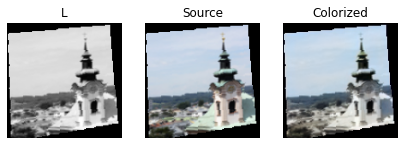

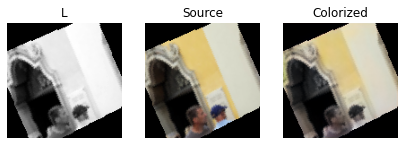

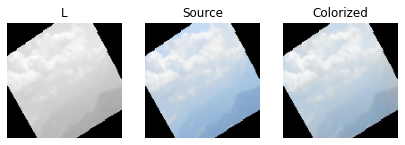

 39%|███▉      | 39/100 [05:54<09:10,  9.02s/it]


Epoch: 40
MSE: 0.001395817962475121


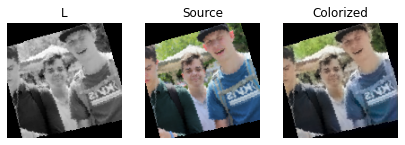

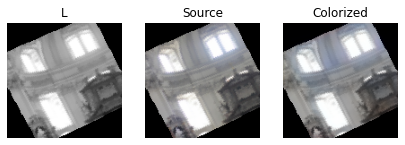

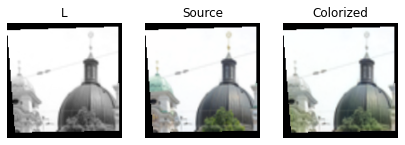

 59%|█████▉    | 59/100 [08:56<06:09,  9.00s/it]


Epoch: 60
MSE: 0.0012754760682582855


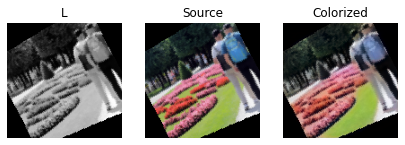

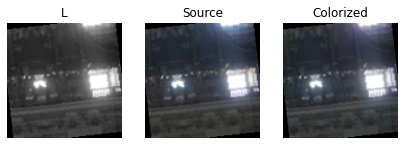

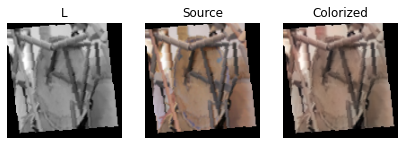

 79%|███████▉  | 79/100 [11:58<03:08,  8.99s/it]


Epoch: 80
MSE: 0.001259727869182825


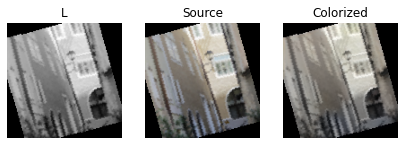

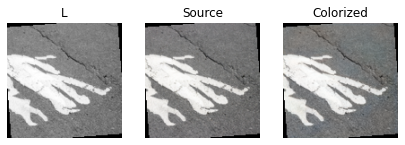

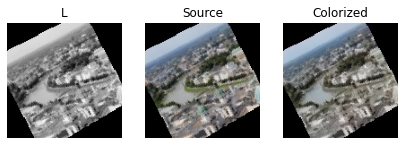

 99%|█████████▉| 99/100 [15:00<00:09,  9.01s/it]


Epoch: 100
MSE: 0.0013786031631752849


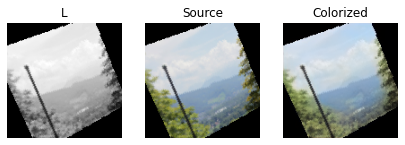

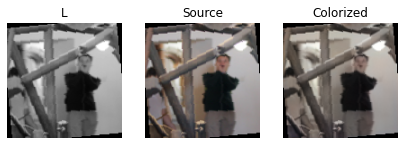

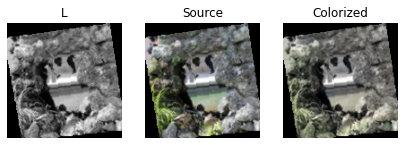

100%|██████████| 100/100 [15:11<00:00,  9.12s/it]


In [23]:
history = []

for epoch in tqdm(range(epochs)):
    for l, ab in loader:
        model.train()

        l = l.to(device).float()
        ab = ab.to(device).float()

        optimizer.zero_grad()

        pred_ab = model(l)

        true_lab = torch.cat((l, ab), dim=1)
        pred_lab = torch.cat((l, pred_ab), dim=1)

        loss = criterion(true_lab, pred_lab)
        history.append(loss.item())

        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        if (epoch + 1) % eval_every == 0:
            torch.save(model.state_dict(), f"gdrive/MyDrive/Kaggle/Colorizer/weights_model_{epoch}.pt")

            print(f"\nEpoch: {epoch + 1}\nMSE: {history[-1]}")
            eval(epoch + 5, epoch + 8)